In [4]:
# Load the relevant packages.
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from scipy import sparse

sc.settings.verbosity = 3 # Possible values: (0) errors, (1) warnings, (2) info, (3) hints
sc.settings.set_figure_params(dpi = 100, facecolor='white', fontsize=18, transparent=True)

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

/Users/xhx/miniconda3/envs/pancrearl/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [5]:
# Load the processed fibroblast and immune data
results_directory = '../data/' # Initialise the results file

In [6]:
# Load the data
results_name = 'integratedskindata.h5ad'
skin_merged = sc.read_h5ad(results_directory + results_name)
unwounded_merged = skin_merged[skin_merged.obs['sample'].isin(['UW P49', 'UW P21'])]

In [10]:
unwounded_merged.shape, skin_merged.shape

((16493, 21485), (107778, 21485))

In [25]:
unwounded_merged.obs.head(5)

,sample,sub_sample,doublet_score,predicted_doublet,batch,n_counts,log_counts,n_genes,pct_counts_mt,leiden,leiden_sub,Cell cycle,S_score,G2M_score,phase
AAACCTGAGCCGTCGT,UW P49,UW_P49_1,0.049375,False,0,9271.0,9.134646,2246,1.617948,EPI-2,SPN-1,-0.148145,-0.025779,-0.138219,G1
AAACCTGCAAGGGTCA,UW P49,UW_P49_1,0.027002,False,0,17606.0,9.775995,3574,1.817562,EPI-2,CYC-2,0.438236,0.000252,0.910893,G2M
AAACCTGCACCCATGG,UW P49,UW_P49_1,0.027002,False,0,4855.0,8.487764,1677,3.501545,EPI-2,BAS-4,-0.124229,0.027550,-0.135667,S
AAACCTGCAGATCCAT,UW P49,UW_P49_1,0.034410,False,0,7270.0,8.891512,2041,2.723521,EPI-2,SPN-1,-0.162793,-0.043022,-0.155258,G1
AAACCTGCAGATCTGT,UW P49,UW_P49_1,0.034410,False,0,4368.0,8.382061,1497,4.532967,EPI-3,BAS-3,-0.140604,-0.072223,-0.095912,G1


In [26]:
# Do some renaming
unwounded_merged.obs['sub_sample'] = unwounded_merged.obs['sub_sample'].cat.rename_categories({'UW_1_H20':'UW_P49_1',
                                                          'UW_1_P20':'UW_P21_1',
                                                          'UW_2_H20':'UW_P49_2',
                                                          'UW_2_P20':'UW_P21_2',
                                                          'UW_3_P20':'UW_P21_3'})

unwounded_merged.obs['sub_sample'] = unwounded_merged.obs['sub_sample'].cat.reorder_categories(['UW_P21_1', 'UW_P21_2',
                                                           'UW_P21_3', 'UW_P49_1',
                                                           'UW_P49_2'])



unwounded_merged.obs['leiden'] = unwounded_merged.obs['leiden'].cat.rename_categories({'Epidermal 1':'EPI-1',
                                                      'Epidermal 2':'EPI-2',
                                                      'Epidermal 3':'EPI-3',
                                                      'Epidermal 4':'EPI-4',
                                                      'Epidermal 5':'EPI-5',
                                                      'Fibroblast 1':'FIB-1',
                                                      'Fibroblast 2':'FIB-2',
                                                      'Fibroblast 3':'FIB-3',
                                                      'Fibroblast 4':'FIB-4',
                                                      'Immune 1':'IMM-1',
                                                      'Immune 2':'IMM-2',
                                                      'Immune 3':'IMM-3',
                                                      'Pericyte':'PERI',
                                                      'Endothelial':'ENDO',
                                                      'Schwann':'SCH',
                                                      'Lymphatic endothelial':'LYM-E',
                                                      'Melanocyte':'MEL',
                                                      'Langerhans cell':'LC',
                                                      'Skeletal muscle':'SKEL',
                                                      'Smooth muscle':'SMC'})

unwounded_merged.obs['leiden'] = unwounded_merged.obs['leiden'].cat.reorder_categories(['EPI-1',
                                                       'EPI-2',
                                                       'EPI-3',
                                                       'EPI-4',
                                                       'EPI-5',
                                                       'FIB-1',
                                                       'FIB-2',
                                                       'FIB-3',
                                                       'FIB-4',
                                                       'IMM-1',
                                                       'IMM-2',
                                                       'IMM-3',
                                                       'PERI',
                                                       'ENDO',
                                                       'SCH',
                                                       'LYM-E',
                                                       'MEL',
                                                       'LC',
                                                       'SKEL',
                                                       'SMC'])

In [49]:
unwounded_merged.obs["leiden_sub"].cat.categories

Index(['BAS-1', 'BAS-2', 'BAS-3', 'BAS-4', 'BAS-5', 'CYC-1', 'CYC-2', 'DC-1',
       'DC-2', 'DC-3', 'ENDO-1', 'ENDO-2', 'ENDO-3', 'ENDO-4', 'FIB-II',
       'FIB-III', 'FIB-IV', 'FIB-IX', 'FIB-VI', 'FIB-VII', 'FIB-VIII', 'FIB-X',
       'HF-1', 'HF-2', 'LC', 'LYME-1', 'LYME-2', 'MAC-1', 'MAC-2', 'MAC-3',
       'BASO', 'MAST', 'MEL', 'NEU', 'PERI-1', 'PERI-2', 'PERI-4', 'PERI-5',
       'RBC', 'SKEL', 'SPN-1', 'SMC', 'TCELL', 'NK', 'WO-1', 'WO-2', 'DP',
       'SCH-1', 'SCH-2', 'SCH-3', 'SCH-4', 'SCH-5', 'pDC'],
      dtype='object')

# Compare across all cell types

In [29]:
unwounded_sccoda = dat.from_scanpy(unwounded_merged,
                                     cell_type_identifier='leiden',
                                     sample_identifier='sub_sample')
unwounded_sccoda.obs['Condition'] = pd.Series(['P21', 'P21', 'P21', 'P49', 'P49']).values

No covariate information specified!


In [20]:
model_uw = mod.CompositionalAnalysis(unwounded_sccoda, formula="Condition", reference_cell_type="automatic")
uw_sccoda_results = model_uw.sample_hmc()

Automatic reference selection! Reference cell type set to MEL
Zero counts encountered in data! Added a pseudocount of 0.5.


  0%|                                                                                                                                                                                              | 0/20000 [00:00<?, ?it/s]2026-01-05 12:25:43.571572: I external/local_xla/xla/service/service.cc:163] XLA service 0x600003b2f300 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-05 12:25:43.571585: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2026-01-05 12:25:43.644704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767644744.059789 186032449 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████

MCMC sampling finished. (199.909 sec)
Acceptance rate: 54.8%


In [21]:
uw_sccoda_results.set_fdr(est_fdr=0.05)
uw_sccoda_results.credible_effects()

Covariate         Cell Type
Condition[T.P49]  EPI-1        False
                  EPI-2         True
                  EPI-3         True
                  EPI-4        False
                  EPI-5        False
                  FIB-1        False
                  FIB-2        False
                  FIB-3        False
                  FIB-4         True
                  IMM-1        False
                  IMM-2        False
                  IMM-3        False
                  PERI          True
                  ENDO          True
                  SCH           True
                  LYM-E         True
                  MEL          False
                  LC           False
                  SKEL         False
                  SMC           True
Name: Final Parameter, dtype: bool

In [22]:
uw_sccoda_results.set_fdr(est_fdr=0.01)
uw_sccoda_results.credible_effects()

Covariate         Cell Type
Condition[T.P49]  EPI-1        False
                  EPI-2         True
                  EPI-3         True
                  EPI-4        False
                  EPI-5        False
                  FIB-1        False
                  FIB-2        False
                  FIB-3        False
                  FIB-4         True
                  IMM-1        False
                  IMM-2        False
                  IMM-3        False
                  PERI         False
                  ENDO          True
                  SCH           True
                  LYM-E         True
                  MEL          False
                  LC           False
                  SKEL         False
                  SMC          False
Name: Final Parameter, dtype: bool

In [23]:
uw_sccoda_results.set_fdr(est_fdr=0.001)
uw_sccoda_results.credible_effects()

Covariate         Cell Type
Condition[T.P49]  EPI-1        False
                  EPI-2         True
                  EPI-3         True
                  EPI-4        False
                  EPI-5        False
                  FIB-1        False
                  FIB-2        False
                  FIB-3        False
                  FIB-4         True
                  IMM-1        False
                  IMM-2        False
                  IMM-3        False
                  PERI         False
                  ENDO          True
                  SCH           True
                  LYM-E         True
                  MEL          False
                  LC           False
                  SKEL         False
                  SMC          False
Name: Final Parameter, dtype: bool

/Users/xhx/miniconda3/envs/pancrearl/lib/python3.11/site-packages/sccoda/util/data_visualization.py:323: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(
/Users/xhx/miniconda3/envs/pancrearl/lib/python3.11/site-packages/sccoda/util/data_visualization.py:335: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


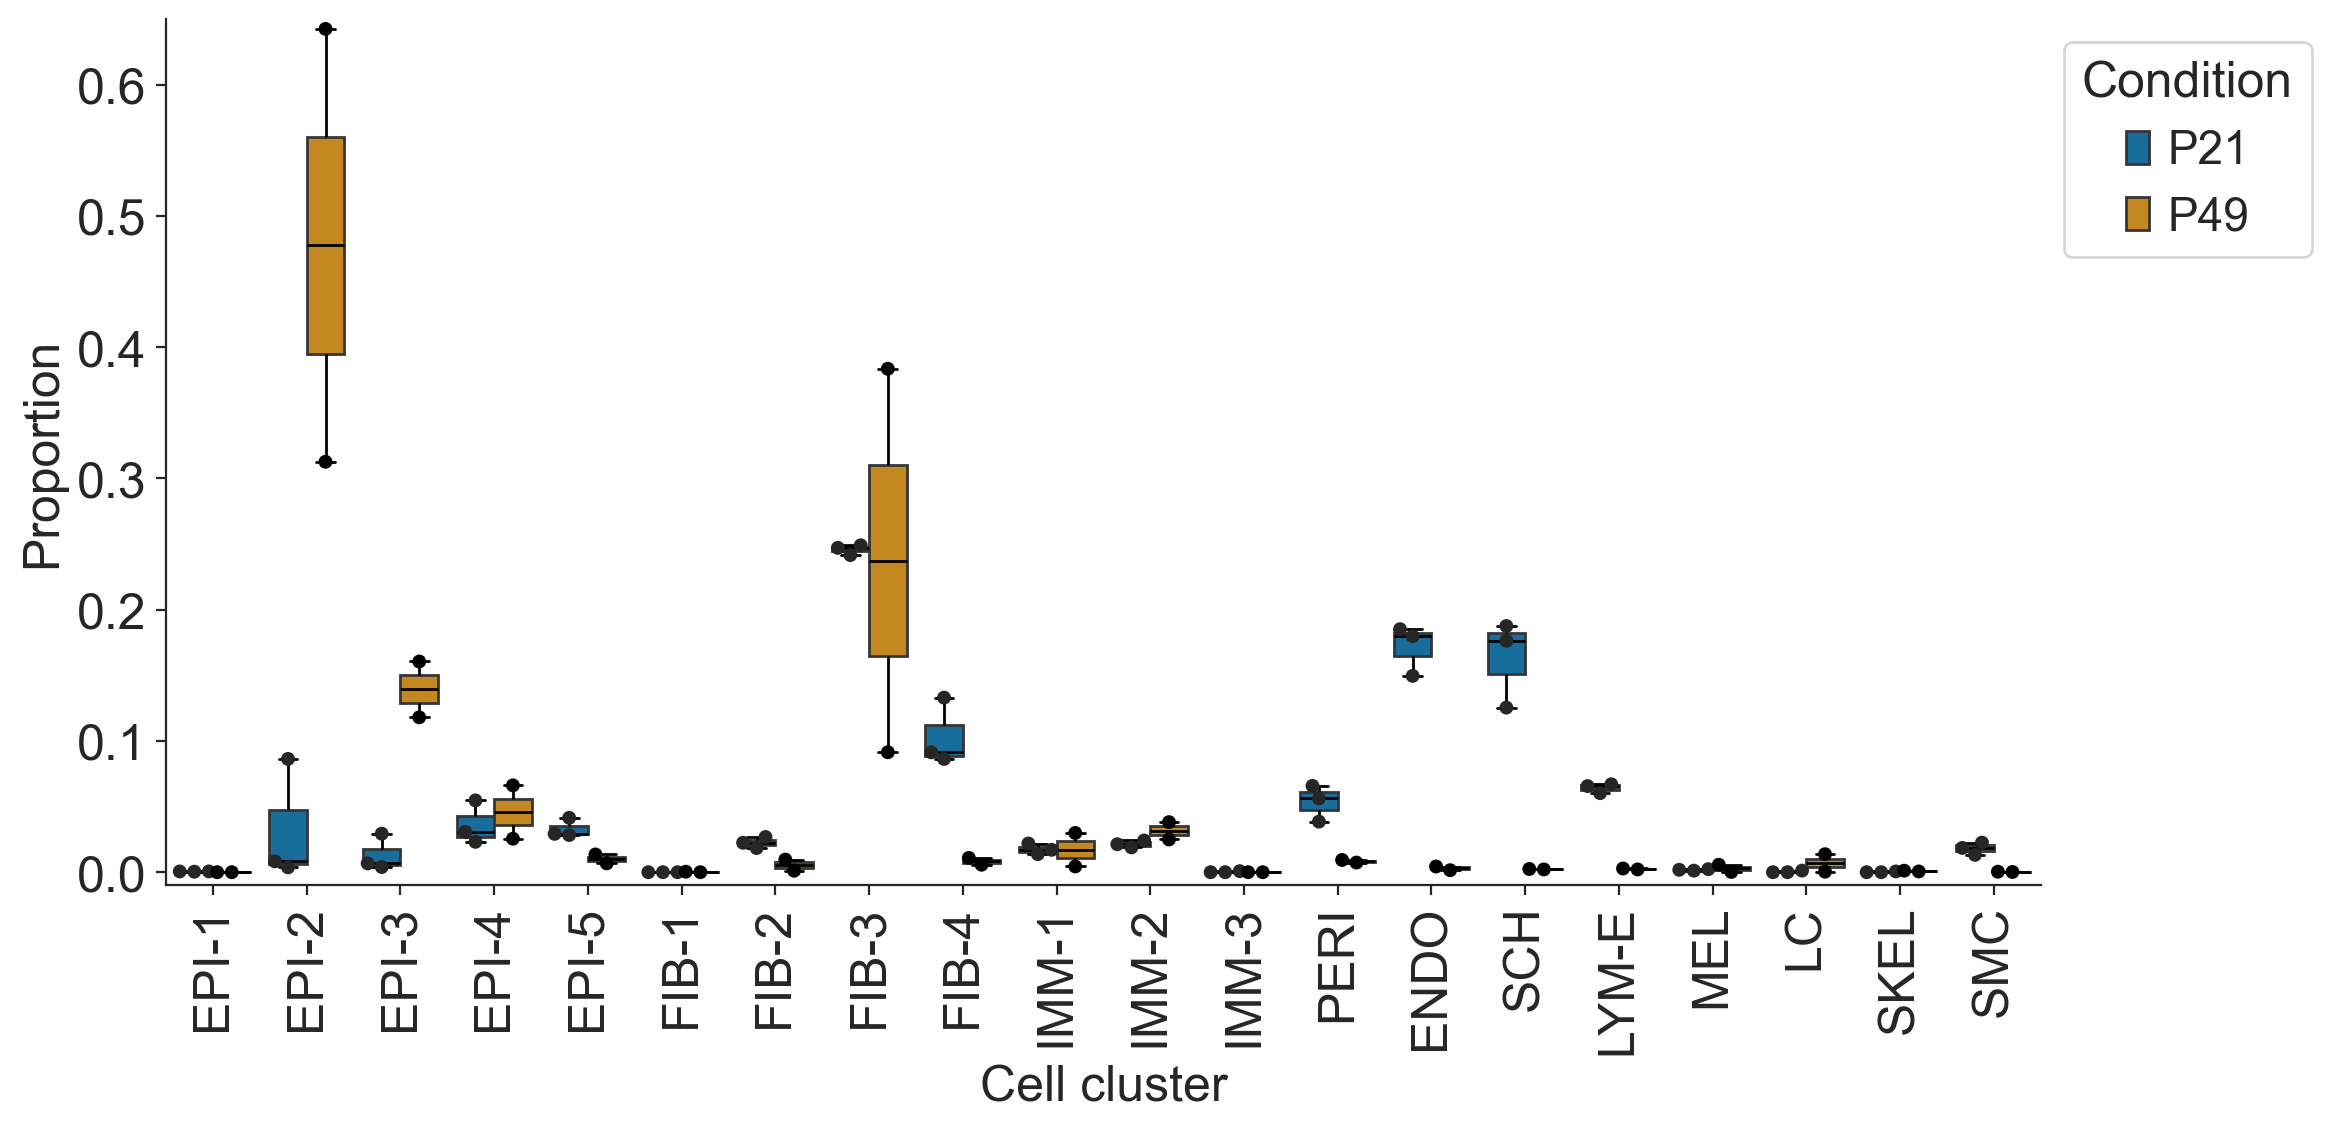

In [24]:
# Plot the different proportions
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Arial'
# fig, ax  = plt.subplots
ax = viz.boxplots(unwounded_sccoda, feature_name="Condition", y_scale='relative', add_dots=True, cmap='colorblind')
plt.ylim(-0.01, 0.65)
plt.xlabel('Cell cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for line in ax.get_lines():
    line.set_color('black')
    

# Epidermal cells only

In [31]:
epidermal_merged = unwounded_merged[unwounded_merged.obs['leiden'].str.startswith('EPI-')]

epidermal_merged.obs['sub_sample'] = epidermal_merged.obs['sub_sample'].cat.rename_categories({'UW_1_H20':'UW_P49_1',
                                                          'UW_1_P20':'UW_P21_1',
                                                          'UW_2_H20':'UW_P49_2',
                                                          'UW_2_P20':'UW_P21_2',
                                                          'UW_3_P20':'UW_P21_3'})

epidermal_merged.obs['sub_sample'] = epidermal_merged.obs['sub_sample'].cat.reorder_categories(['UW_P21_1', 'UW_P21_2',
                                                           'UW_P21_3', 'UW_P49_1',
                                                           'UW_P49_2'])

/var/folders/8c/yxjlv7693rs95qvx0m69x7q00000gn/T/ipykernel_29412/1619646775.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  epidermal_merged.obs['sub_sample'] = epidermal_merged.obs['sub_sample'].cat.rename_categories({'UW_1_H20':'UW_P49_1',


In [32]:
# Define scCODA object
epidermal_sccoda = dat.from_scanpy(epidermal_merged,
                                     cell_type_identifier='leiden_sub',
                                     sample_identifier='sub_sample')
epidermal_sccoda.obs['Condition'] = pd.Series(['P21', 'P21', 'P21', 'P49', 'P49']).values

No covariate information specified!


In [33]:
# Train model
model_epi = mod.CompositionalAnalysis(epidermal_sccoda, formula="Condition", reference_cell_type="automatic")
epi_sccoda_results = model_epi.sample_hmc()

Automatic reference selection! Reference cell type set to HF-1
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:27<00:00, 718.96it/s]


MCMC sampling finished. (36.307 sec)
Acceptance rate: 53.0%


In [34]:
epi_sccoda_results.set_fdr(est_fdr=0.05)
epi_sccoda_results.credible_effects()

Covariate         Cell Type
Condition[T.P49]  BAS-1        False
                  BAS-2         True
                  BAS-3        False
                  BAS-4        False
                  BAS-5        False
                  CYC-1        False
                  CYC-2        False
                  HF-1         False
                  HF-2          True
                  SPN-1        False
                  WO-1         False
                  WO-2         False
Name: Final Parameter, dtype: bool

In [35]:
epi_sccoda_results.set_fdr(est_fdr=0.01)
epi_sccoda_results.credible_effects()

Covariate         Cell Type
Condition[T.P49]  BAS-1        False
                  BAS-2         True
                  BAS-3        False
                  BAS-4        False
                  BAS-5        False
                  CYC-1        False
                  CYC-2        False
                  HF-1         False
                  HF-2          True
                  SPN-1        False
                  WO-1         False
                  WO-2         False
Name: Final Parameter, dtype: bool

In [36]:
epi_sccoda_results.set_fdr(est_fdr=0.001)
epi_sccoda_results.credible_effects()

Covariate         Cell Type
Condition[T.P49]  BAS-1        False
                  BAS-2         True
                  BAS-3        False
                  BAS-4        False
                  BAS-5        False
                  CYC-1        False
                  CYC-2        False
                  HF-1         False
                  HF-2          True
                  SPN-1        False
                  WO-1         False
                  WO-2         False
Name: Final Parameter, dtype: bool

/Users/xhx/miniconda3/envs/pancrearl/lib/python3.11/site-packages/sccoda/util/data_visualization.py:323: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(
/Users/xhx/miniconda3/envs/pancrearl/lib/python3.11/site-packages/sccoda/util/data_visualization.py:335: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


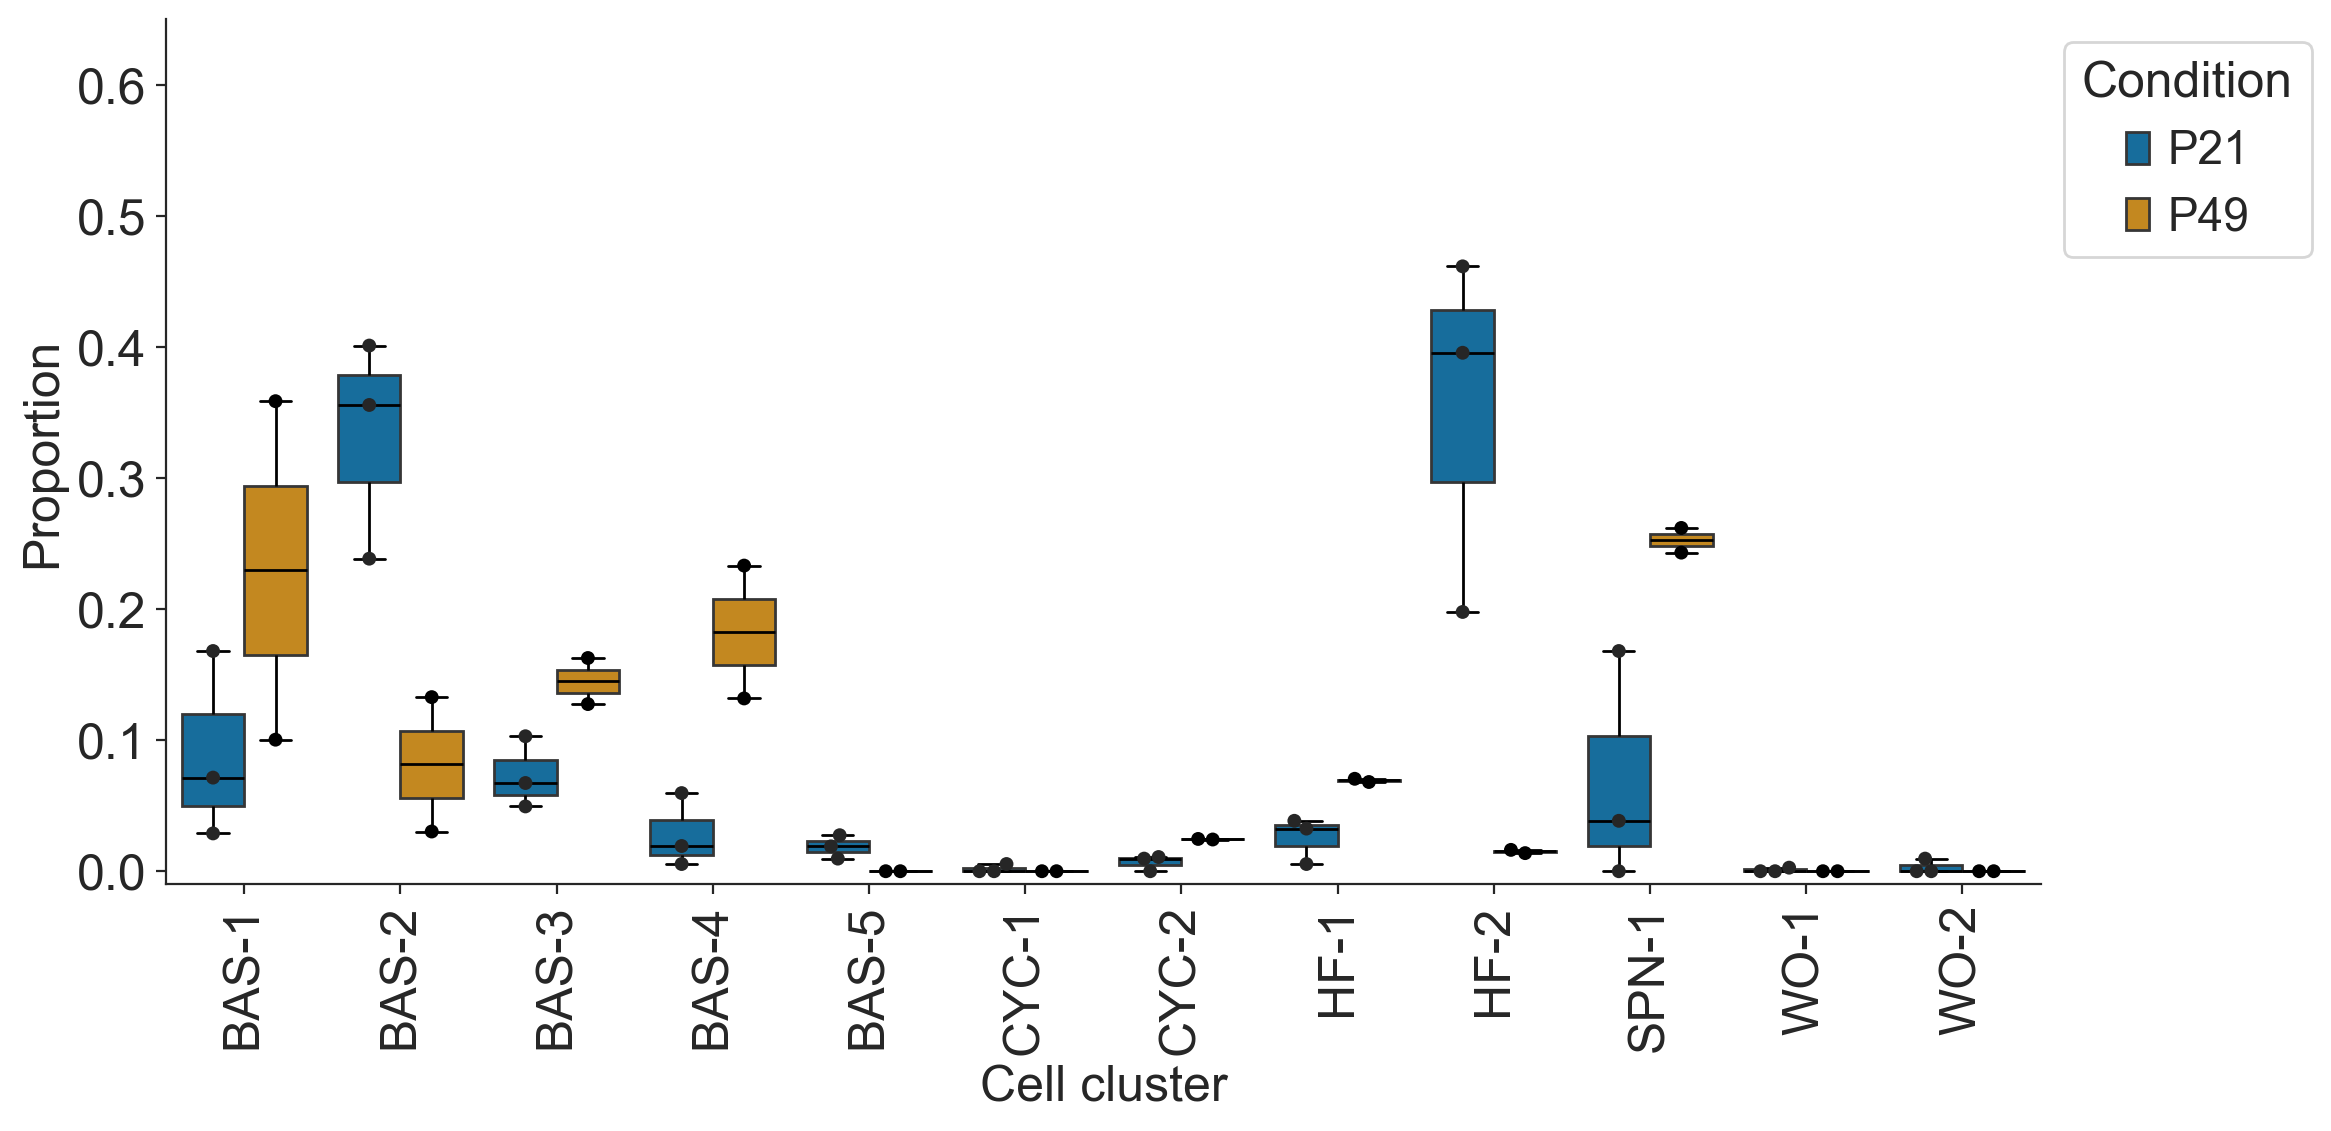

In [37]:
# Plot the different proportions
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Arial'
# fig, ax  = plt.subplots
ax = viz.boxplots(epidermal_sccoda, feature_name="Condition", y_scale='relative', add_dots=True, cmap='colorblind')
plt.ylim(-0.01, 0.65)
plt.xlabel('Cell cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for line in ax.get_lines():
    line.set_color('black')
    

# Fibroblasts

In [ ]:
# Isolate fibroblasts this way to avoid the initial batch of RBCs
fibroblast_merged = unwounded_merged[unwounded_merged.obs['leiden'].str.startswith('FIB')]
fibroblast_merged = fibroblast_merged[fibroblast_merged.obs['leiden_sub'] != 'RBC']

fibroblast_merged.obs['sub_sample'].cat.rename_categories({'UW_1_H20':'UW_P49_1',
                                                          'UW_1_P20':'UW_P21_1',
                                                          'UW_2_H20':'UW_P49_2',
                                                          'UW_2_P20':'UW_P21_2',
                                                          'UW_3_P20':'UW_P21_3'}, inplace=True)

fibroblast_merged.obs['sub_sample'].cat.reorder_categories(['UW_P21_1', 'UW_P21_2',
                                                           'UW_P21_3', 'UW_P49_1',
                                                           'UW_P49_2'], inplace=True)

fibroblast_merged.obs['leiden_sub'].cat.reorder_categories(['DP', 'FIB-II', 'FIB-III', 'FIB-IV',
                                                            'FIB-VI', 'FIB-VII', 'FIB-VIII', 'FIB-IX',
                                                            'FIB-X'], inplace=True)

In [ ]:
fibroblast_sccoda = dat.from_scanpy(fibroblast_merged,
                                     cell_type_identifier='leiden_sub',
                                     sample_identifier='sub_sample')
fibroblast_sccoda.obs['Condition'] = pd.Series(['P21', 'P21', 'P21', 'P49', 'P49']).values

In [ ]:
# Train model
model_fib = mod.CompositionalAnalysis(fibroblast_sccoda, formula="Condition", reference_cell_type="automatic")
fib_sccoda_results = model_fib.sample_hmc()

In [ ]:
fib_sccoda_results.set_fdr(est_fdr=0.05)
fib_sccoda_results.credible_effects()

In [ ]:
fib_sccoda_results.set_fdr(est_fdr=0.01)
fib_sccoda_results.credible_effects()

In [ ]:
fib_sccoda_results.set_fdr(est_fdr=0.001)
fib_sccoda_results.credible_effects()

In [ ]:
# Plot the different proportions
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Arial'
# fig, ax  = plt.subplots
ax = viz.boxplots(fibroblast_sccoda, feature_name="Condition", y_scale='relative', add_dots=True, cmap='colorblind')
plt.ylim(-0.01, 0.65)
plt.xlabel('Cell cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for line in ax.get_lines():
    line.set_color('black')
    

# Immune cells

In [ ]:
immune_merged = unwounded_merged[unwounded_merged.obs['leiden'].str.startswith('Immune')]
immune_merged = immune_merged[immune_merged.obs['leiden_sub'] != 'RBC']

immune_merged.obs['sub_sample'].cat.rename_categories({'UW_1_H20':'UW_P49_1',
                                                          'UW_1_P20':'UW_P21_1',
                                                          'UW_2_H20':'UW_P49_2',
                                                          'UW_2_P20':'UW_P21_2',
                                                          'UW_3_P20':'UW_P21_3'}, inplace=True)

immune_merged.obs['sub_sample'].cat.reorder_categories(['UW_P21_1', 'UW_P21_2',
                                                           'UW_P21_3', 'UW_P49_1',
                                                           'UW_P49_2'], inplace=True)

In [ ]:
immune_sccoda = dat.from_scanpy(immune_merged,
                                     cell_type_identifier='leiden_sub',
                                     sample_identifier='sub_sample')
immune_sccoda.obs['Condition'] = pd.Series(['P21', 'P21', 'P21', 'P49', 'P49']).values

In [ ]:
model_imm = mod.CompositionalAnalysis(immune_sccoda, formula="Condition", reference_cell_type="automatic")
immune_sccoda_results = model_imm.sample_hmc()

In [ ]:
immune_sccoda_results.set_fdr(est_fdr=0.05)
immune_sccoda_results.credible_effects()

In [ ]:
immune_sccoda_results.set_fdr(est_fdr=0.01)
immune_sccoda_results.credible_effects()

In [ ]:
immune_sccoda_results.set_fdr(est_fdr=0.001)
immune_sccoda_results.credible_effects()

In [ ]:
# Plot the different proportions
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Arial'
# fig, ax  = plt.subplots
ax = viz.boxplots(immune_sccoda, feature_name="Condition", y_scale='relative', add_dots=True, cmap='colorblind')
plt.ylim(-0.01, 0.65)
plt.xlabel('Cell cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for line in ax.get_lines():
    line.set_color('black')
    

# Pericytes

In [ ]:
pericyte_merged = unwounded_merged[unwounded_merged.obs['leiden'] == 'PERI']

pericyte_merged.obs['sub_sample'].cat.rename_categories({'UW_1_H20':'UW_P49_1',
                                                          'UW_1_P20':'UW_P21_1',
                                                          'UW_2_H20':'UW_P49_2',
                                                          'UW_2_P20':'UW_P21_2',
                                                          'UW_3_P20':'UW_P21_3'}, inplace=True)

pericyte_merged.obs['sub_sample'].cat.reorder_categories(['UW_P21_1', 'UW_P21_2',
                                                           'UW_P21_3', 'UW_P49_1',
                                                           'UW_P49_2'], inplace=True)

In [ ]:
pericyte_sccoda = dat.from_scanpy(pericyte_merged,
                                     cell_type_identifier='leiden_sub',
                                     sample_identifier='sub_sample')
pericyte_sccoda.obs['Condition'] = pd.Series(['P21', 'P21', 'P21', 'P49', 'P49']).values

In [ ]:
model_peri = mod.CompositionalAnalysis(pericyte_sccoda, formula="Condition", reference_cell_type="automatic")
pericyte_sccoda_results = model_peri.sample_hmc()

In [ ]:
pericyte_sccoda_results.set_fdr(est_fdr=0.05)
pericyte_sccoda_results.credible_effects()

In [ ]:
pericyte_sccoda_results.set_fdr(est_fdr=0.01)
pericyte_sccoda_results.credible_effects()

In [ ]:
pericyte_sccoda_results.set_fdr(est_fdr=0.001)
pericyte_sccoda_results.credible_effects()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.family'] = 'Arial'
# fig, ax  = plt.subplots
ax = viz.boxplots(pericyte_sccoda, feature_name="Condition", y_scale='relative', add_dots=True, cmap='colorblind')
plt.ylim(-0.01, 0.9)
plt.xlabel('Cell cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for line in ax.get_lines():
    line.set_color('black')
# plt.show()

# Endothelial cells

In [ ]:
endothelial_merged = unwounded_merged[unwounded_merged.obs['leiden'].str.startswith('ENDO')]

endothelial_merged.obs['sub_sample'].cat.rename_categories({'UW_1_H20':'UW_P49_1',
                                                          'UW_1_P20':'UW_P21_1',
                                                          'UW_2_H20':'UW_P49_2',
                                                          'UW_2_P20':'UW_P21_2',
                                                          'UW_3_P20':'UW_P21_3'}, inplace=True)

endothelial_merged.obs['sub_sample'].cat.reorder_categories(['UW_P21_1', 'UW_P21_2',
                                                           'UW_P21_3', 'UW_P49_1',
                                                           'UW_P49_2'], inplace=True)

In [ ]:
endothelial_sccoda = dat.from_scanpy(endothelial_merged,
                                     cell_type_identifier='leiden_sub',
                                     sample_identifier='sub_sample')
endothelial_sccoda.obs['Condition'] = pd.Series(['P21', 'P21', 'P21', 'P49', 'P49']).values

In [ ]:
model_endo = mod.CompositionalAnalysis(endothelial_sccoda, formula="Condition", reference_cell_type="automatic")
endo_sccoda_results = model_endo.sample_hmc()

In [ ]:
endo_sccoda_results.set_fdr(est_fdr=0.05)
endo_sccoda_results.credible_effects()

In [ ]:
endo_sccoda_results.set_fdr(est_fdr=0.01)
endo_sccoda_results.credible_effects()

In [ ]:
endo_sccoda_results.set_fdr(est_fdr=0.001)
endo_sccoda_results.credible_effects()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.family'] = 'Arial'
# fig, ax  = plt.subplots
ax = viz.boxplots(endothelial_sccoda, feature_name="Condition", y_scale='relative', add_dots=True, cmap='colorblind')
plt.ylim(-0.01, 0.9)
plt.xlabel('Cell cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for line in ax.get_lines():
    line.set_color('black')
# plt.show()

# Schwann cells

In [ ]:
schwann_merged = unwounded_merged[unwounded_merged.obs['leiden'].str.startswith('SCH')]

schwann_merged.obs['sub_sample'].cat.rename_categories({'UW_1_H20':'UW_P49_1',
                                                          'UW_1_P20':'UW_P21_1',
                                                          'UW_2_H20':'UW_P49_2',
                                                          'UW_2_P20':'UW_P21_2',
                                                          'UW_3_P20':'UW_P21_3'}, inplace=True)

schwann_merged.obs['sub_sample'].cat.reorder_categories(['UW_P21_1', 'UW_P21_2',
                                                           'UW_P21_3', 'UW_P49_1',
                                                           'UW_P49_2'], inplace=True)

In [ ]:
schw_sccoda = dat.from_scanpy(schwann_merged,
                                     cell_type_identifier='leiden_sub',
                                     sample_identifier='sub_sample')
schw_sccoda.obs['Condition'] = pd.Series(['P21', 'P21', 'P21', 'P49', 'P49']).values

In [ ]:
model_schw = mod.CompositionalAnalysis(schw_sccoda, formula="Condition", reference_cell_type="automatic")
schw_sccoda_results = model_schw.sample_hmc()

In [ ]:
schw_sccoda_results.set_fdr(est_fdr=0.05)
schw_sccoda_results.credible_effects()

In [ ]:
schw_sccoda_results.set_fdr(est_fdr=0.01)
schw_sccoda_results.credible_effects()

In [ ]:
schw_sccoda_results.set_fdr(est_fdr=0.001)
schw_sccoda_results.credible_effects()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.family'] = 'Arial'
# fig, ax  = plt.subplots
ax = viz.boxplots(schw_sccoda, feature_name="Condition", y_scale='relative', add_dots=True, cmap='colorblind')
plt.ylim(-0.01, 0.9)
plt.xlabel('Cell cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for line in ax.get_lines():
    line.set_color('black')
# plt.show()